In [13]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from functools import partial
import pandas as pd
from IPython.display import display
import ipywidgets as widgets

# Control of oscillations (OOP version)

In [41]:
# To define an oscillation class, required properties are model (model), parameters (params), constants (consts) and the conservative relations of species (calc_all)
# Format of calc_all: calc_all(sol: solution of solve_ivp, consts: np.array) -> all concentrations: np.array
# Species are strictly in the order of (A2, S, A, O)
class oscillation:
    def __init__(self, model, params, consts, init_cond, calc_all):

        # Model and parameters
        self.__model = model
        self.__params = params
        self.__consts = consts
        self.__calc_all = calc_all
        self.__init_cond = init_cond

        # Essential information
        self.__species = ['A2', 'S_sum', 'A', 'O']
        self.__info = None

        # Experimental data
        self.__exp_data = None

    @property
    def info(self):
        print(
            f'The model includes {len(self.__params)} parameters and {len(self.__consts)} constants. The species are {self.__species}. Initial condition: {self.__init_cond}')
        print(f'Additional information: {self.__info}')

    def add_info(self, info):
        self.__info = info

    def simulate(self, t=10, t_eval='default', init_cond = None):
        params_pass = np.hstack((self.__params, self.__consts))
        model_partial = partial(self.__model, params=params_pass)
        t_span = (0, t)

        if type(t_eval) == str:
            t_eval = np.linspace(0, t, 500)

        #Default: initial condition is passed by the property. It can also be passed by external input

        if isinstance(init_cond, (np.ndarray, list, tuple)):
            y0 = init_cond
        else:
            y0 = self.__init_cond

        sol = solve_ivp(model_partial, t_span=t_span,
                        y0=y0, method='RK45', t_eval=t_eval, rtol=1e-6, atol=1e-8)
        return sol

    def plot(self, t=10, exp=False):
        i = 0
        if exp == True:
            y0 = [np.array(self.__exp_data.iloc[0, 1]), np.array(self.__exp_data.iloc[0, 3])]
            sol = self.simulate(t=self.__exp_data.iloc[-1, 0], init_cond=y0)
            c = self.__calc_all(sol, self.__consts)
            fig, axes = plt.subplots(2, 1, figsize=(8, 12))
            for ax in axes:
                ax.plot(
                    self.__exp_data.iloc[:, 2*i], self.__exp_data.iloc[:, 2*i+1], label=f'exp-{self.__species[i]}')
                ax.plot(sol.t, c[i], label=self.__species[i])
                ax.legend()
                i += 1
        else:
            sol = self.simulate(t)
            c = self.__calc_all(sol, self.__consts)
            fig, axes = plt.subplots(2, 2, figsize=(10, 6))
            for ax, y in zip(axes.flatten(), c):
                ax.plot(sol.t, y, label=self.__species[i])
                ax.legend()
                i += 1

        return fig, ax

    def interactive_plot(self, t=10, range=5, step=0.05, exp=False):

        if len(self.__params) == 4:
            print('4 parameters')

            def plot_temp(alpha, beta, theta, phi):
                params_old = self.__params
                params = [alpha, beta, theta, phi]
                self.__params = params
                self.plot(t, exp=exp)
                self.__params = params_old

            alpha, beta, theta, phi = self.__params
            alpha_slider = widgets.FloatSlider(value=alpha, min=max(
                0, alpha-range), max=alpha+range, step=step, description='alpha')
            beta_slider = widgets.FloatSlider(value=beta, min=max(
                0, beta-range), max=beta+range, step=step, description='beta')
            theta_slider = widgets.FloatSlider(value=theta, min=max(
                0, theta-range), max=theta+range, step=step, description='theta')
            phi_slider = widgets.FloatSlider(value=phi, min=max(
                0, phi-range), max=phi+range, step=step, description='phi')

            interactive_widget = widgets.interactive(
                plot_temp, alpha=alpha_slider, beta=beta_slider, theta=theta_slider, phi=phi_slider)
            display(interactive_widget)

        elif len(self.__params) == 5:
            print('5 parameters')
            pass

    def add_exp_data(self, exp_data):
        print(
            f'The species are {self.__species}. Please check if the data is in the same order and correct format (time, concentration).')
        data = exp_data.clip(lower=0)
        self.__exp_data = data

    def set_params(self, params):
        self.__params = params

    def fit(self, plot=False, overwrite=False):
        tA2 = np.array(self.__exp_data.iloc[:, 0])
        cA2 = np.array(self.__exp_data.iloc[:, 1])
        tS = np.array(self.__exp_data.iloc[:, 2])
        cS = np.array(self.__exp_data.iloc[:, 3])

        if self.__exp_data.shape[1] >= 4:
            tA = np.array(self.__exp_data.iloc[:, 4])
            cA = np.array(self.__exp_data.iloc[:, 5])

        t_span_A2 = tA2[-1]
        t_span_S = tS[-1]
        init_cond = [cA2[0], cS[0]]

        def objective(params):
            self.__params = params
            simA2 = self.simulate(t=t_span_A2, t_eval=tA2, init_cond=init_cond)
            simS = self.simulate(t=t_span_S, t_eval=tS, init_cond=init_cond)
            c_all_A2 = self.__calc_all(simA2, self.__consts)
            c_all_S = self.__calc_all(simS, self.__consts)

            penalty = 1e10 * np.sum(np.minimum(self.__params, 0) ** 2)

            obj = np.sum((c_all_A2[0] - cA2)**2 +
                         (c_all_S[1] - cS)**2) + penalty
            return obj

        params_old = self.__params

        opt_result = sp.optimize.minimize(
            objective, self.__params, method='Nelder-Mead', tol=1e-6)
        print(
            f'alpha = {self.__params[0]:.3f}, beta = {self.__params[1]:.3f}, theta = {self.__params[2]:.3f}, phi = {self.__params[3]:.3f}')

        if plot == True:
            self.plot(init_cond, exp=True)

        if overwrite == False:
            self.__params = params_old
        return opt_result

In [3]:
# Params includes alpha, beta, theta, phi, lam, m in the final model

def approx_model_FTC(t, vars, params):
    alpha, beta, theta, phi, lam, m = params
    C_A2, C_S = vars
    dC_A2dt = 1 - alpha * C_A2 * C_S**m - theta * C_A2
    dC_Sdt = alpha/lam * C_A2 * C_S**m - beta * \
        C_S**(m + 1) + theta/lam * C_A2 - phi * C_S
    return (dC_A2dt, dC_Sdt)

def calc_all_approx_model_FTC(sol, consts):
    lam, m = consts
    C_A2 = sol.y[0]
    C_S = sol.y[1]
    C_M = C_S ** m
    C_A = 2 * (1 - C_A2) - lam * (C_S + C_M)
    C_O = 1 / (2 * (1 - C_A2) - lam * (C_S + C_M)) ** 2
    return np.array([C_A2, C_S + C_M, C_A, C_O])

In [4]:
files = ['Data_sets/1_expB_osc_NatChem_MH.csv',
         'Data_sets/3b_expB_osc_NatChem_MH.csv',
         'Data_sets/4_expB_osc_NatChem_MH.csv']

df_list = [pd.read_csv(file) for file in files]

exp_data = pd.concat(df_list, axis=1)

exp_data.columns = ['t1', 'c1', 't3b', 'c3b', 't4', 'c4']

cut_off, CMC_3b = 112, 0.52
C_A2tol = exp_data.loc[0, 'c1'] + exp_data.loc[0, 'c4'] / 2

exp_data = exp_data.head(cut_off)
exp_data[['c1', 'c4']] /= C_A2tol
exp_data['c3b'] /= CMC_3b

for s in ['t1', 't3b', 't4']:
    exp_data = exp_data.drop_duplicates(subset=s)

exp_data = exp_data.clip(lower=0)

In [5]:
params = np.array([24, 1, 3.5, 10])
consts = np.array([0.17, 4])
init_cond = np.array([0.1, 0])

model_test = oscillation(approx_model_FTC, params, consts, init_cond, calc_all_approx_model_FTC)
model_test.add_info('This is a test model. The original Fernando\'s model')
model_test.add_exp_data(exp_data)

The species are ['A2', 'S_sum', 'A', 'O']. Please check if the data is in the same order and correct format (time, concentration).


In [6]:
model_test.info

The model includes 4 parameters and 2 constants. The species are ['A2', 'S_sum', 'A', 'O']. Initial condition: [0.1 0. ]
Additional information: This is a test model. The original Fernando's model


alpha = 23.737, beta = 1.012, theta = 3.211, phi = 10.365


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 23.96680182711822
             x: [ 2.374e+01  1.012e+00  3.211e+00  1.036e+01]
           nit: 157
          nfev: 408
 final_simplex: (array([[ 2.374e+01,  1.012e+00,  3.211e+00,  1.036e+01],
                       [ 2.374e+01,  1.012e+00,  3.211e+00,  1.036e+01],
                       ...,
                       [ 2.374e+01,  1.012e+00,  3.211e+00,  1.036e+01],
                       [ 2.374e+01,  1.012e+00,  3.211e+00,  1.036e+01]]), array([ 2.397e+01,  2.397e+01,  2.397e+01,  2.397e+01,
                        2.397e+01]))

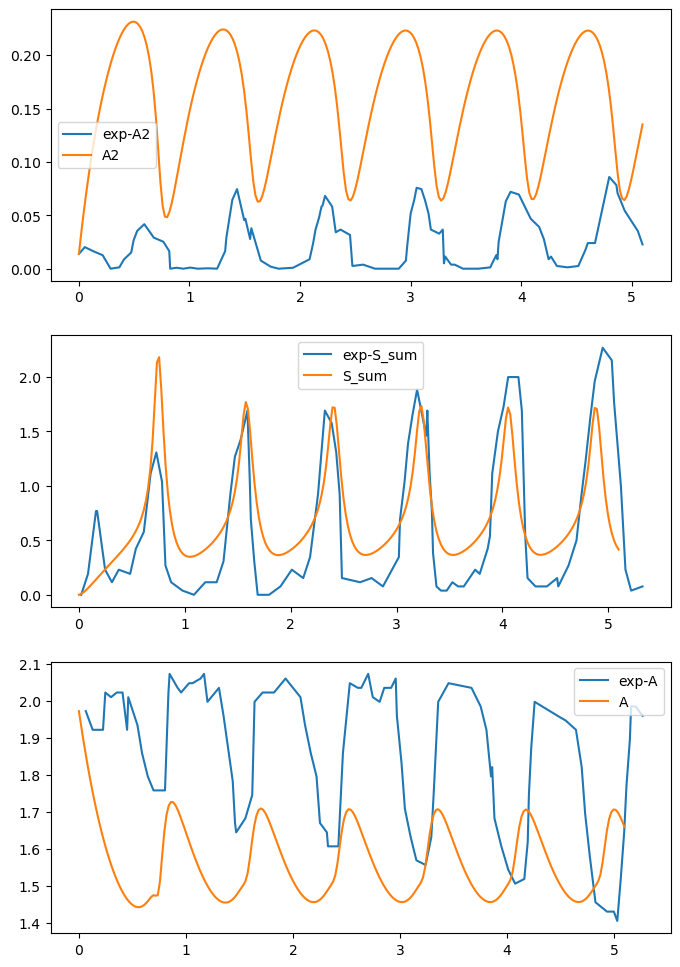

In [11]:
model_test.fit(plot=True, overwrite=True)

In [12]:
model_test.interactive_plot(exp=True)

4 parameters


interactive(children=(FloatSlider(value=23.73680217837221, description='alpha', max=28.73680217837221, min=18.…

# Full model (may have problems)

In [9]:
def full_model_FTC(t, vars, params):
    alpha, beta, theta, phi, lam, m, ep, delta = params
    cA2, cS, cO, cM = vars
    
    cA2 = np.clip(cA2, -1e6, 1e6)
    cS = np.clip(cS, -1e6, 1e6)
    cO = np.clip(cO, -1e6, 1e6)
    cM = np.clip(cM, -1e6, 1e6)

    dcA2dt = cO * (2 * (1 - cA2) - lam * (cS + cM))**2 - alpha * cM * cA2 - theta * cA2
    dcSdt = alpha/lam * cM * cA2 - beta * cM * cS + theta/lam * cA2 - phi * cS - 1/delta * (cS**m - cM)
    dcMdt = 1/delta * (cS**m - cM)
    dcOdt = 1/ep * (1 - cO * (2 * (1 - cA2) - lam * (cS + cM))**2)

    return dcA2dt, dcSdt, dcMdt, dcOdt

def calc_all_full_model_FTC(sol, const):
    lam, m, ep, delta = const
    cA2, cS, cM, cO = sol.y
    cS_sum = cS + cM
    cA = 2 * (1 - cA2) - lam * (cS + cM)
    return cA2, cS_sum, cA, cO

params = [24, 1, 3.5, 10]
consts = [0.17, 4, 1e-4, 1e-4]
init_cond = [1, 0, 0, 0.2]

full_model = oscillation(full_model_FTC, params, consts, init_cond, calc_all_full_model_FTC)
full_model.info

The model includes 4 parameters and 4 constants. The species are ['A2', 'S_sum', 'A', 'O']. Initial condition: [1, 0, 0, 0.2]
Additional information: None


(<Figure size 1000x600 with 4 Axes>, <Axes: >)

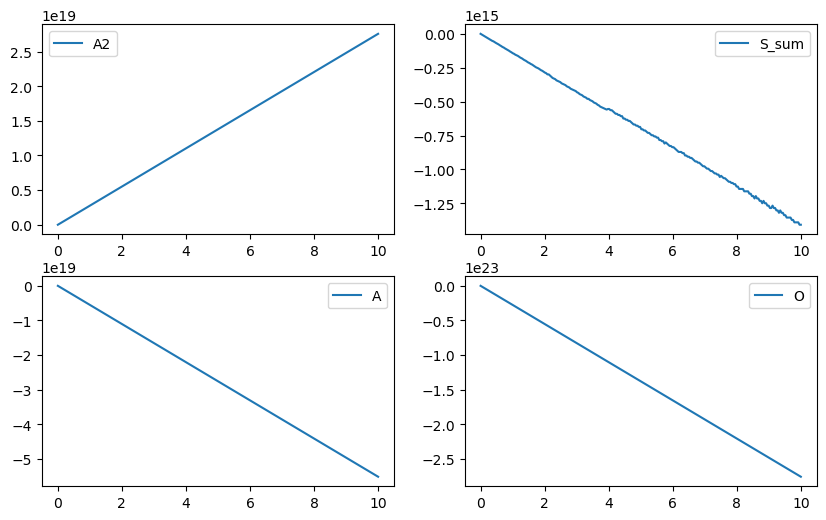

In [10]:
full_model.plot()

In [55]:
df_400uL_700rpm = pd.read_csv(r'C:\Users\chem-sedm6967\OneDrive - Nexus365\Desktop\01_projects\01_oscillation modelling\Chemical_Oscillation_Model\Data_sets\C81_400uL_700_LM.csv')
df_400uL_700rpm = df_400uL_700rpm.clip(lower=0)

#Normalization
cmc = 0.22
cA2_sum0 = 14.5
tau = 0.26

df_400uL_700rpm['cA2'] /= cA2_sum0
df_400uL_700rpm['cS'] /= cmc
df_400uL_700rpm[['tA2', 'tS']] /= 60 * tau

In [56]:
params = np.array([1, 1, 1, 1])
consts = np.array([0.015, 4])
init_cond = ([df_400uL_700rpm['cA2'].iloc[0], 0])
osc_400uL_700rpm = oscillation(approx_model_FTC, params, consts, init_cond, calc_all_approx_model_FTC)
osc_400uL_700rpm.add_exp_data(df_400uL_700rpm)

The species are ['A2', 'S_sum', 'A', 'O']. Please check if the data is in the same order and correct format (time, concentration).


In [58]:
osc_400uL_700rpm.interactive_plot(t=5, range=50, step=0.1, exp=True)

4 parameters


interactive(children=(FloatSlider(value=1.0, description='alpha', max=51.0), FloatSlider(value=1.0, descriptio…